In [46]:
import argparse, os, warnings, torch
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import shapiro, ttest_rel, wilcoxon
from src.metrics import *

warnings.filterwarnings(action='ignore')
pd.set_option("display.max_rows", None)


def darken_color(color, amount=0.3):
    c = mcolors.to_rgb(color)
    return mcolors.to_hex([max(0, min(1, c[0] * (1 - amount))),
                           max(0, min(1, c[1] * (1 - amount))),
                           max(0, min(1, c[2] * (1 - amount)))])

def calculate_metrics(group):
    total_count = len(group)  # 총 데이터 수
    tbr_count = (group['BG'] < 70).sum()  # TBR (70 이하)
    tar_count = (group['BG'] >= 180).sum()  # TAR (180 이상)
    tir_count = ((group['BG'] >= 70) & (group['BG'] < 180)).sum()  # TIR (70~180 사이)
    tbr54_count = (group['BG'] < 54).sum()  # TBR54 (54 이하)
    tar250_count = (group['BG'] >= 250).sum()  # TAR250 (250 이상)
    
    group = group.sort_values(by='Time')
    group['Time_diff'] = pd.to_datetime(group['Time']).diff().dt.total_seconds() / 60  # 분 단위 차이
    hypo_durations = group.loc[group['BG'] < 70, 'Time_diff'].fillna(0).sum()  # 총 저혈당 지속 시간
    hyper_durations = group.loc[group['BG'] > 180, 'Time_diff'].fillna(0).sum()  # 총 고혈당 지속 시간

    glucose_std = group['CGM'].std()  # 표준편차 (SD)
    glucose_cv = (glucose_std / group['CGM'].mean()) * 100  # 변동계수 (CV%)

    return pd.Series({
        'Total_Count': total_count,
        'TBR (%)': (tbr_count / total_count) * 100 if total_count > 0 else 0,
        'TAR (%)': (tar_count / total_count) * 100 if total_count > 0 else 0,
        'TIR (%)': (tir_count / total_count) * 100 if total_count > 0 else 0,
        'TBR54 (%)': (tbr54_count / total_count) * 100 if total_count > 0 else 0,
        'TAR250 (%)': (tar250_count / total_count) * 100 if total_count > 0 else 0,
        'Hypoglycemia Duration (min)': hypo_durations,
        'Hyperglycemia Duration (min)': hyper_durations,
        'Glucose CV (%)': glucose_cv  # 변동계수 (CV%)
    })

def get_sens_spec(true, pred):
    # true_binary, pred_binary = (true<70)*1, (pred<70)*1
    cm = confusion_matrix(true, pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sens, spec

def get_sens_spec_event(true, pred, window_size=3):
    true_rolled = []
    pred_rolled = []
    
    for i in range(len(true) - window_size + 1):
        if np.all(true[i:i+window_size] == 1):  # 3개의 연속된 값이 모두 1일 때
            true_rolled.append(1)
        else:
            true_rolled.append(0)
        
        if np.all(pred[i:i+window_size] == 1):  # 3개의 연속된 값이 모두 1일 때
            pred_rolled.append(1)
        else:
            pred_rolled.append(0)
    
    sens, spec = get_sens_spec(true, pred)
    return sens, spec

def get_significance(p):
    if p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''
    
def create_timepoints(start, end):
    return pd.DataFrame({'datetime': pd.date_range(start=start, end=end, freq='5T')})

def RMSE(true, pred):
    return np.sqrt(np.sum((true - pred)**2)/len(true))

def MAE(true, pred):
    return np.sum(abs(true - pred))/len(true)

# VP

In [2]:
file_paths = ['../../../Vega/TDImodel_scenario2/result/HMJ_noLGS/',  # No Control
              '../../../Vega/TDImodel_scenario2/result/HMJ_VanillaLGS/',  # current CGM < 70
              '../../../Vega/TDImodel_scenario2/result/HMJ_gSL_REG/',  # predicted CGM < 70
              '../../../Vega/TDImodel_scenario2/result/HMJ_gSL_CLF/',  # CLF: 0.5
              '../../../Vega/TDImodel_scenario2/result/HMJ_Test/'
              ]

results = pd.DataFrame()
for fp in file_paths:
    df_list = []
    print(f"[File Path: {fp.split('/')[-2]}]")
    for file_name in os.listdir(fp):
        if file_name.endswith(".csv"):
            file_path = os.path.join(fp, file_name)
            df = pd.read_csv(file_path)
            df['SID'] = int(file_name.split('_')[1].split('#')[1])
            df_list.append(df)

    all_df = pd.concat(df_list, ignore_index=True)
    all_df['Day'] = pd.to_datetime(all_df.Time).apply(lambda x: x.strftime('%y%m%d'))

    result_df = all_df.groupby(['SID']).apply(calculate_metrics).reset_index()    
    display(result_df.agg(['mean','std']).round(2))
    print('-' * 50)
    
    result_df['Phase'] = fp.split('/')[-2]
    results = pd.concat([results, result_df], axis=0)

[File Path: HMJ_noLGS]


,SID,Total_Count,TBR (%),TAR (%),TIR (%),TBR54 (%),TAR250 (%),Hypoglycemia Duration (min),Hyperglycemia Duration (min),Glucose CV (%)
mean,5.50,9217.0,7.15,37.45,55.39,3.34,15.94,3297.00,17260.50,40.60
std,3.03,0.0,4.71,21.11,17.66,2.30,19.62,2169.26,9727.42,4.25


--------------------------------------------------
[File Path: HMJ_VanillaLGS]


,SID,Total_Count,TBR (%),TAR (%),TIR (%),TBR54 (%),TAR250 (%),Hypoglycemia Duration (min),Hyperglycemia Duration (min),Glucose CV (%)
mean,5.50,9217.0,2.06,39.12,58.82,0.28,16.45,949.50,18026.50,37.6
std,3.03,0.0,1.22,19.59,18.78,0.30,19.81,560.27,9027.64,3.2


--------------------------------------------------
[File Path: HMJ_gSL_REG]


,SID,Total_Count,TBR (%),TAR (%),TIR (%),TBR54 (%),TAR250 (%),Hypoglycemia Duration (min),Hyperglycemia Duration (min),Glucose CV (%)
mean,5.50,9217.0,6.22,36.78,57.00,2.86,15.68,2868.50,16948.50,40.28
std,3.03,0.0,3.75,20.50,17.82,1.63,19.51,1730.29,9447.53,3.36


--------------------------------------------------
[File Path: HMJ_gSL_CLF]


,SID,Total_Count,TBR (%),TAR (%),TIR (%),TBR54 (%),TAR250 (%),Hypoglycemia Duration (min),Hyperglycemia Duration (min),Glucose CV (%)
mean,5.50,9217.0,0.50,39.61,59.89,0.02,16.59,230.50,18254.50,36.75
std,3.03,0.0,0.24,19.72,19.68,0.04,19.66,108.49,9089.72,2.96


--------------------------------------------------
[File Path: HMJ_Test]


,SID,Total_Count,TBR (%),TAR (%),TIR (%),TBR54 (%),TAR250 (%),Hypoglycemia Duration (min),Hyperglycemia Duration (min),Glucose CV (%)
mean,5.50,9217.0,2.01,39.81,58.18,0.24,16.62,927.00,18348.00,37.43
std,3.03,0.0,1.27,20.10,19.28,0.22,19.49,587.22,9263.13,3.05


--------------------------------------------------


In [3]:
results = pd.read_csv("Results/Control/Integrated_ByPhases.csv")
phase_order = ['HMJ_noLGS','HMJ_VanillaLGS','HMJ_gSL_CLF']
results['Phase'] = pd.Categorical(results['Phase'], categories=phase_order, ordered=True)
results.loc[results.Phase.isin(phase_order), \
['Phase', 'TBR (%)', 'TBR54 (%)','TIR (%)','TAR (%)', 'TAR250 (%)','Hypoglycemia Duration (min)',\
'Hyperglycemia Duration (min)', 'Glucose CV (%)']]\
.groupby('Phase').agg(['mean', 'std']).round(2)

TBR (%)       TBR54 (%)       TIR (%)        TAR (%)         \
                  mean   std      mean   std    mean    std    mean    std   
Phase                                                                        
HMJ_noLGS         7.15  4.71      3.34  2.30   55.39  17.66   37.45  21.11   
HMJ_VanillaLGS    2.06  1.22      0.28  0.30   58.82  18.78   39.12  19.59   
HMJ_gSL_CLF       0.50  0.24      0.02  0.04   59.89  19.68   39.61  19.72   

               TAR250 (%)        Hypoglycemia Duration (min)           \
                     mean    std                        mean      std   
Phase                                                                   
HMJ_noLGS           15.94  19.62                      3297.0  2169.26   
HMJ_VanillaLGS      16.45  19.81                       949.5   560.27   
HMJ_gSL_CLF         16.59  19.66                       230.5   108.49   

               Hyperglycemia Duration (min)          Glucose CV (%)        
                                       mean      std           mean   std  
Phase                                                                      
HMJ_noLGS                           17260.5  9727.42          40.60  4.25  
HMJ_VanillaLGS                      18026.5  9027.64          37.60  3.20  
HMJ_gSL_CLF                         18254.5  9089.72          36.75  2.96

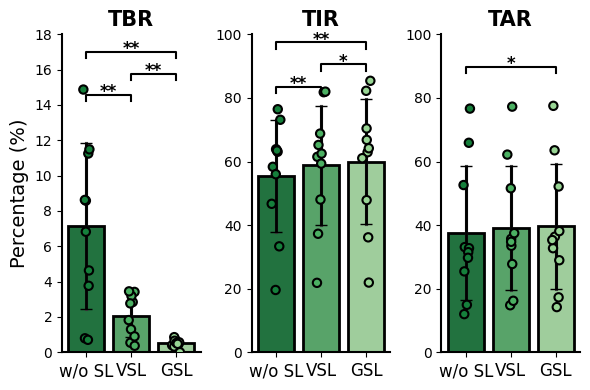

,RMSE,MAE,SENS,SPEC,F1
mean,11.90,8.15,93.04,97.24,0.37
std,1.59,1.26,4.53,2.03,0.17


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_rel, wilcoxon

results = pd.read_csv("Results/Control/Integrated_ByPhases.csv")

phase_order = ['HMJ_noLGS', 'HMJ_VanillaLGS', 'HMJ_gSL_CLF']
results['Phase'] = pd.Categorical(results['Phase'], categories=phase_order, ordered=True)
results.rename(columns={'TBR (%)': 'TBR', 'TIR (%)': 'TIR', 'TAR (%)': 'TAR'}, inplace=True)
selected_metrics = ['TBR', 'TIR', 'TAR']

palette = sns.color_palette("Greens_r", n_colors=4)
phase_colors = {phase_order[i]: palette[i] for i in range(3)}

fig, axes = plt.subplots(1, 3, figsize=(6,4))
pivot_results = results.pivot_table(index='SID', columns='Phase', values=selected_metrics)
for i, metric in enumerate(selected_metrics):
    ax = axes[i]
    bars = sns.barplot(x='Phase', y=metric, data=results, order=phase_order, ax=ax, palette=phase_colors, ci="sd", 
                       errorbar=True, linewidth=2, edgecolor='black')
    sns.stripplot(x='Phase', y=metric, data=results, order=phase_order, ax=ax, 
                  palette=phase_colors, edgecolor='black', linewidth=1.5, size=6)
    
    means, stds = results.groupby('Phase')[metric].mean(), results.groupby('Phase')[metric].std()

    for j, phase in enumerate(phase_order):
        ax.errorbar(x=j, y=means[phase], yerr=stds[phase], fmt='none',
                    ecolor='black', capsize=4, linewidth=2)
        
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); ax.spines['bottom'].set_linewidth(1.5); ax.spines['left'].set_linewidth(1.5);

    pivot_metric = pivot_results[metric]

    group1, group2, group3 = pivot_metric['HMJ_noLGS'].dropna(), pivot_metric['HMJ_VanillaLGS'].dropna(), pivot_metric['HMJ_gSL_CLF'].dropna()
    group12, group13, group23 = pivot_metric[['HMJ_noLGS', 'HMJ_VanillaLGS']].dropna(), pivot_metric[['HMJ_noLGS', 'HMJ_gSL_CLF']].dropna(), pivot_metric[['HMJ_VanillaLGS', 'HMJ_gSL_CLF']].dropna()

    p_norm_12 = shapiro(group12['HMJ_noLGS'] - group12['HMJ_VanillaLGS']).pvalue
    p_norm_13 = shapiro(group13['HMJ_noLGS'] - group13['HMJ_gSL_CLF']).pvalue
    p_norm_23 = shapiro(group23['HMJ_VanillaLGS'] - group23['HMJ_gSL_CLF']).pvalue

    pairs = [
        ("noLGS vs VanillaLGS", group12['HMJ_noLGS'], group12['HMJ_VanillaLGS'], 0, 1, p_norm_12),
        ("VanillaLGS vs gSL_CLF", group23['HMJ_VanillaLGS'], group23['HMJ_gSL_CLF'], 1, 2, p_norm_23),
        ("noLGS vs gSL_CLF", group13['HMJ_noLGS'], group13['HMJ_gSL_CLF'], 0, 2, p_norm_13),
    ]

    y_max = results[metric].max()
    y_spacing = y_max * 0.09 

    for idx, (label, g1, g2, x1, x2, p_norm) in enumerate(pairs):
        test_name = "paired t-test" if p_norm >= 0.05 else "Wilcoxon signed-rank"
        stat, p_val = (ttest_rel(g1, g2) if p_norm >= 0.05 else wilcoxon(g1, g2))
        sig = get_significance(p_val)
        if sig:
            y_level = y_max + y_spacing * (idx + 0.7)
            ax.plot([x1, x1, x2, x2],
                    [y_level-y_level*0.1, y_level-y_level*0.08, y_level-y_level*0.08, y_level-y_level*0.1],
                    lw=1.5, color='black')
            ax.text((x1 + x2) / 2, y_level-y_level*0.1, sig, ha='center', va='bottom',
                    fontsize=12, fontweight='bold')

    ax.set_ylim([0, 18] if metric == 'TBR' else [0, 100])
    ax.set_xticklabels(["w/o SL", "VSL", "GSL"], fontsize=12)
    ax.set_xlabel(""); ax.set_ylabel("Percentage (%)" if i == 0 else "", fontsize=14);
    ax.set_title(metric, fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

result_df = []
for i in range(1, 11, 1):
    a = pd.read_csv(f"../../../Vega/TDImodel_scenario2/result/HMJ_gSL_CLF/PredictedData/pred_adult_new#{i:03d}.csv")
    
    rmse = calculate_rmse(a.true_cgm, a.pred_reg_mean)
    mae = calculate_mae(a.true_cgm, a.pred_reg_mean)
    sens, spec = get_sens_spec_event((a.true_cgm<70)*1, (a.pred_clf>0.5)*1)
    f1 = calculate_f1score((a.true_cgm<70)*1, (a.pred_clf>0.5)*1)    
    result_df.append([f'Adult#{i:02d}', rmse, mae, sens*100, spec*100, f1])
result_df = pd.DataFrame(result_df, columns = ['SID','RMSE', 'MAE', 'SENS', 'SPEC', 'F1'])

result_df.loc[:, ['RMSE', 'MAE', 'SENS', 'SPEC', 'F1']].agg(['mean', 'std']).round(2)

Text(0.5, 1.0, 'Multi-task based Glucose Level Prediction & Hypoglycemia Detection')

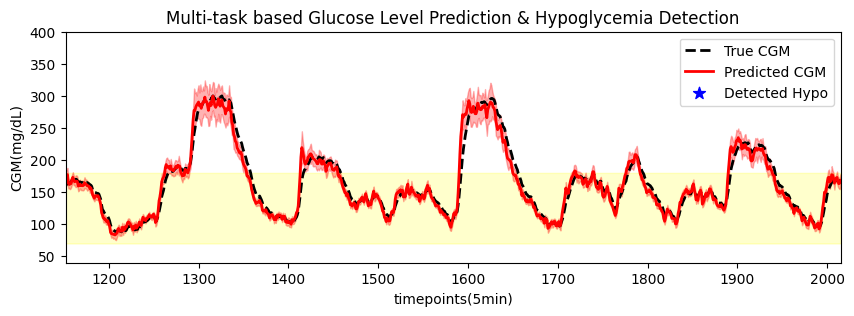

In [9]:
a['clf'] = (a.pred_clf > 0.5) * 1
l = np.arange(288*4, 288*7)

plt.figure(figsize = (10,3))
plt.fill_between(a.index[l], 70, 180, color='yellow', alpha=0.2)
plt.plot(a.true_cgm[l], label = 'True CGM', color='black', ls='--', lw=2)
plt.plot(a.pred_reg_mean[l], label ='Predicted CGM', color='red', ls='-', lw=2)
plt.fill_between(a.index[l], a.pred_reg_mean[l] - a.pred_reg_std[l]*2, a.pred_reg_mean[l] + a.pred_reg_std[l]*2, color='red', alpha=0.3)

plt.xlim([a.index[l][0],a.index[l][-1]])
plt.ylim([40,400])

plt.scatter(a[a.index.isin(l) & a.clf == 1].index, a[a.index.isin(l) & a.clf == 1].pred_reg_mean, 
            label ='Detected Hypo', color='blue', marker='*', s=80, zorder=10)


plt.legend()

plt.xlabel('timepoints(5min)')
plt.ylabel('CGM(mg/dL)')
plt.title('Multi-task based Glucose Level Prediction & Hypoglycemia Detection')

In [7]:
result_df = []
for i in range(1, 11, 1):
    a = pd.read_csv(f"../../../Vega/TDImodel_scenario2/result/HMJ_Test/PredictedData/pred_adult_new#{i:03d}.csv")
    
    rmse = calculate_rmse(a.true_cgm, a.pred_reg_mean)
    mae = calculate_mae(a.true_cgm, a.pred_reg_mean)
    sens, spec = get_sens_spec_event((a.true_cgm<70)*1, (a.pred_clf>0.5)*1)
    f1 = calculate_f1score((a.true_cgm<70)*1, (a.pred_clf>0.5)*1)    
    result_df.append([f'Adult#{i:02d}', rmse, mae, sens*100, spec*100, f1])
result_df = pd.DataFrame(result_df, columns = ['SID','RMSE', 'MAE', 'SENS', 'SPEC', 'F1'])

rmse: 12.45, mae: 8.55, sens: 87.18, spec: 97.20, f1: 68.84
rmse: 11.60, mae: 8.08, sens: 94.29, spec: 93.96, f1: 57.12
rmse: 10.57, mae: 8.03, sens: 92.90, spec: 94.96, f1: 60.55
rmse: 9.71, mae: 6.94, sens: 93.90, spec: 98.48, f1: 68.90
rmse: 10.89, mae: 7.82, sens: 90.91, spec: 99.81, f1: 75.95
rmse: 14.87, mae: 10.36, sens: 96.15, spec: 91.24, f1: 48.64
rmse: 13.75, mae: 9.47, sens: 86.52, spec: 99.28, f1: 67.54
rmse: 12.62, mae: 8.95, sens: 97.78, spec: 98.98, f1: 49.72
rmse: 13.14, mae: 8.93, sens: 92.05, spec: 98.08, f1: 72.75
rmse: 9.78, mae: 6.93, sens: 95.44, spec: 95.05, f1: 51.86


In [8]:
result_df.loc[:, ['RMSE', 'MAE', 'SENS', 'SPEC', 'F1']].agg(['mean', 'std']).round(2)

,RMSE,MAE,SENS,SPEC,F1
mean,11.94,8.41,92.71,96.70,0.62
std,1.72,1.08,3.68,2.79,0.10


In [16]:
import pandas as pd

def calculate_metrics(group):
    total_count = len(group)  # 총 데이터 수
    tbr_count = (group['BG'] < 70).sum()  # TBR (70 이하)
    tar_count = (group['BG'] > 180).sum()  # TAR (180 이상)
    tir_count = ((group['BG'] >= 70) & (group['BG'] <= 180)).sum()  # TIR (70~180 사이)
    tbr54_count = (group['BG'] < 54).sum()  # TBR54 (54 이하)
    tar250_count = (group['BG'] > 250).sum()  # TAR250 (250 이상)

    return pd.Series({
        'Total_Count': total_count,
        'TBR (%)': (tbr_count / total_count) * 100 if total_count > 0 else 0,
        'TAR (%)': (tar_count / total_count) * 100 if total_count > 0 else 0,
        'TIR (%)': (tir_count / total_count) * 100 if total_count > 0 else 0,
        'TBR54 (%)': (tbr54_count / total_count) * 100 if total_count > 0 else 0,
        'TAR250 (%)': (tar250_count / total_count) * 100 if total_count > 0 else 0,
    })



file_paths = ['../../../Vega/TDImodel_scenario2/result/MinjooPaper2025_NoLGS_General/', # No Control
              '../../../Vega/TDImodel_scenario2/result/MinjooPaper2025_VanillaLGS/',#current CGM < 70
              '../../../Vega/TDImodel_scenario2/result/MinjooPaper2025_VanillaLGS_Predicted/', #predicted CGM < 70
              '../../../Vega/TDImodel_scenario2/result/MinjooPaper2025_generalDACMTL_LGS/', #CLF: 0.5
             ]

for fp in file_paths:
    df_list = []
    print(f"File Path: {fp.split('/')[-2]}")
    for file_name in os.listdir(fp):
        if file_name.endswith(".csv"):
            file_path = os.path.join(fp, file_name)

            df = pd.read_csv(file_path)
            df['SID'] = int(file_name.split('_')[1].split('#')[1])
            df_list.append(df)

    all_df = pd.concat(df_list, ignore_index=True)
    
    tbr = (len(all_df[all_df.CGM<70])/len(all_df))*100
    tbr54 = (len(all_df[all_df.CGM<54])/len(all_df))*100
    tir = (len(all_df[(all_df.CGM>=70)&(all_df.CGM<180)])/len(all_df))*100
    tar = (len(all_df[all_df.CGM>=180])/len(all_df))*100
    
    print(f'TBR54: {tbr54}, TBR: {tbr}, TIR: {tir}, TAR: {tar}\n') 
    all_df['Day'] = pd.to_datetime(all_df.Time).apply(lambda x: x.strftime('%y%m%d'))
    
    result_df = all_df.groupby(['SID', 'Day']).apply(calculate_metrics).reset_index()
    display(result_df.drop(columns = ['Day']).groupby('SID').agg(['mean']).mean())
    print('-'*50)

File Path: MinjooPaper2025_NoLGS_General
TBR54: 18.79570359119019, TBR: 22.58327004448302, TIR: 48.28252142779647, TAR: 29.134208527720517



Total_Count  mean    279.303030
TBR (%)      mean      9.785354
TAR (%)      mean     34.625421
TIR (%)      mean     55.589226
TBR54 (%)    mean      5.723906
TAR250 (%)   mean     13.732113
dtype: float64

--------------------------------------------------
File Path: MinjooPaper2025_VanillaLGS
TBR54: 13.484864923510903, TBR: 14.37669523706195, TIR: 44.79874145600521, TAR: 40.824563306932845



Total_Count  mean    279.303030
TBR (%)      mean      0.916456
TAR (%)      mean     47.737795
TIR (%)      mean     51.345749
TBR54 (%)    mean      0.053662
TAR250 (%)   mean     22.159091
dtype: float64

--------------------------------------------------
File Path: MinjooPaper2025_VanillaLGS_Predicted
TBR54: 13.41651296517305, TBR: 13.618313985027667, TIR: 37.73028100249539, TAR: 48.65140501247694



Total_Count  mean    279.303030
TBR (%)      mean      0.169402
TAR (%)      mean     56.339436
TIR (%)      mean     43.491162
TBR54 (%)    mean      0.008418
TAR250 (%)   mean     30.154672
dtype: float64

--------------------------------------------------
File Path: MinjooPaper2025_generalDACMTL_LGS
TBR54: 13.399153737658676, TBR: 13.454486275360747, TIR: 38.91830313551047, TAR: 47.62721058912878



Total_Count  mean    279.303030
TBR (%)      mean      0.032618
TAR (%)      mean     55.265152
TIR (%)      mean     44.702231
TBR54 (%)    mean      0.000000
TAR250 (%)   mean     28.741582
dtype: float64

--------------------------------------------------


## T-Test: Abliation Study

Single-Task: Prediction이 Prediction 이 가장 정확하며, 이를 DA-CMTL과 비교하였을때 차이가 유의하지 않다는 것을 증명하기 위함.

In [19]:
import pandas as pd
import numpy as np

ewc_diatrend,ewc_shanghait1dm,ewc_ohiot1dm = pd.read_csv('Results/Performance_sub/Table_DiaTrend_PH30.csv', index_col=0),\
        pd.read_csv('Results/Performance_sub/Table_ShanghaiT1DM_PH30.csv', index_col=0),\
        pd.read_csv('Results/Performance_sub/Table_OhioT1DM_PH30.csv', index_col=0)
ewc_diatrend['dataset_name'], ewc_shanghait1dm['dataset_name'], ewc_ohiot1dm['dataset_name'] = 'DiaTrend', 'ShanghaiT1DM', 'OhioT1DM'
ewc_res = pd.concat([ewc_diatrend, ewc_ohiot1dm, ewc_shanghait1dm])
ewc_res = ewc_res[(ewc_res.CL_Type == 'EWC21')&(ewc_res.FT_Type == 'Frozen')&(ewc_res.Tune_length == 3)]

ewc_reg_diatrend,ewc_reg_shanghait1dm,ewc_reg_ohiot1dm = pd.read_csv('Results/Abliation_Study/Performance_sub/Table_DiaTrend_EWC21_PH30_REG.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_ShanghaiT1DM_EWC21_PH30_REG.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_OhioT1DM_EWC21_PH30_REG.csv', index_col=0)
ewc_reg_diatrend['dataset_name'], ewc_reg_shanghait1dm['dataset_name'], ewc_reg_ohiot1dm['dataset_name'] = 'DiaTrend', 'ShanghaiT1DM', 'OhioT1DM'
ewc_reg_res = pd.concat([ewc_reg_diatrend, ewc_reg_ohiot1dm, ewc_reg_shanghait1dm])
ewc_reg_res['CL_Type']= [cl+'_REG' for cl in ewc_reg_res['CL_Type']]

ewc_clf_diatrend, ewc_clf_shanghait1dm, ewc_clf_ohiot1dm = pd.read_csv('Results/Abliation_Study/Performance_sub/Table_DiaTrend_EWC21_PH30_CLF.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_ShanghaiT1DM_EWC21_PH30_CLF.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_OhioT1DM_EWC21_PH30_CLF.csv', index_col=0)
ewc_clf_diatrend['dataset_name'], ewc_clf_shanghait1dm['dataset_name'], ewc_clf_ohiot1dm['dataset_name'] = 'DiaTrend', 'ShanghaiT1DM', 'OhioT1DM'
ewc_clf_res = pd.concat([ewc_clf_diatrend, ewc_clf_ohiot1dm, ewc_clf_shanghait1dm])
ewc_clf_res['CL_Type']= [cl+'_CLF' for cl in ewc_clf_res['CL_Type']]

sd_diatrend, sd_shanghait1dm, sd_ohiot1dm = pd.read_csv('Results/Abliation_Study/Performance_sub/Table_DiaTrend_SD_PH30.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_ShanghaiT1DM_SD_PH30.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_OhioT1DM_SD_PH30.csv', index_col=0)
sd_diatrend['dataset_name'], sd_shanghait1dm['dataset_name'], sd_ohiot1dm['dataset_name'] = 'DiaTrend', 'ShanghaiT1DM', 'OhioT1DM'
sd_res = pd.concat([sd_diatrend, sd_shanghait1dm, sd_ohiot1dm])

naive_diatrend, naive_shanghait1dm, naive_ohiot1dm = pd.read_csv('Results/Abliation_Study/Performance_sub/Table_DiaTrend_MD_NAIVE21_PH30.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_ShanghaiT1DM_MD_NAIVE21_PH30.csv', index_col=0),\
        pd.read_csv('Results/Abliation_Study/Performance_sub/Table_OhioT1DM_MD_NAIVE21_PH30.csv', index_col=0)
naive_diatrend['dataset_name'], naive_shanghait1dm['dataset_name'], naive_ohiot1dm['dataset_name'] = 'DiaTrend', 'ShanghaiT1DM', 'OhioT1DM'
naive_res = pd.concat([naive_diatrend, naive_shanghait1dm, naive_ohiot1dm])
naive_res = naive_res.loc[naive_res.CL_Type == 'NAIVE21']

res = pd.concat([ewc_res, ewc_reg_res, sd_res, naive_res])
res = res[(res.FT_Type == 'Frozen')&(res.Tune_length == 3)]

In [20]:
from scipy.stats import shapiro
from scipy import stats

for dataset_name in ['ShanghaiT1DM', 'OhioT1DM', 'DiaTrend']:
    print(f"<<{dataset_name}>>")
    res_st_pred = res[(res.CL_Type=='EWC21_REG')&(res.dataset_name == dataset_name)]
    res_ours = res[(res.CL_Type=='EWC21')&(res.dataset_name == dataset_name)]

    # -- 정규성 확인 (Normality Test): Shapiro Test
    shap_t1 = shapiro(res_st_pred.RMSE)
    shap_t2 = shapiro(res_ours.RMSE)
    print(f"1. [Normality] Shapiro Test \n 1. ST-Model: {shap_t1} --> {'Normal' if shap_t1[1]>0.05 else 'Not Normal'}\n 2. Ours: {shap_t2} --> {'Normal' if shap_t2[1]>0.05 else 'Not Normal'}") # p>0.05 일 경우 정규 분포를 따름

    l, p = stats.levene(shap_t1,shap_t2)
    print(f"2. [Homegeneity] Levene Test : {p} -->  {'유의하다' if p>0.05 else '유의하지 않다'}")

    print(f"\n결과적으로, 정규성 O, 등분산성 X이므로 Whelch's T-Test를 진행하였다.")
    _, p = stats.ttest_ind(res_st_pred.RMSE, res_ours.RMSE, equal_var=False)
    print(f"p-value: {p} --> {'Same Mean' if p>=0.05 else 'Different Mean'}") # p>=0.05이면 같은 모평균을 가짐
    print('-'*80)

<<ShanghaiT1DM>>
1. [Normality] Shapiro Test 
 1. ST-Model: ShapiroResult(statistic=0.9180333072236526, pvalue=0.41410941169766285) --> Normal
 2. Ours: ShapiroResult(statistic=0.9386399950679054, pvalue=0.5977504084203258) --> Normal
2. [Homegeneity] Levene Test : 2.3186353368041527e-31 -->  유의하지 않다

결과적으로, 정규성 O, 등분산성 X이므로 Whelch's T-Test를 진행하였다.
p-value: 0.9640215994425717 --> Same Mean
--------------------------------------------------------------------------------
<<OhioT1DM>>
1. [Normality] Shapiro Test 
 1. ST-Model: ShapiroResult(statistic=0.9370262414893002, pvalue=0.4861941953706615) --> Normal
 2. Ours: ShapiroResult(statistic=0.9498200035899982, pvalue=0.6416540588297721) --> Normal
2. [Homegeneity] Levene Test : 1.513975619286458e-31 -->  유의하지 않다

결과적으로, 정규성 O, 등분산성 X이므로 Whelch's T-Test를 진행하였다.
p-value: 0.7550932503281642 --> Same Mean
--------------------------------------------------------------------------------
<<DiaTrend>>
1. [Normality] Shapiro Test 
 1. ST-Model: Sh

# Rat

In [33]:
def get_dt_info(rat_num):
    match rat_num:
        case 1:
            woSL_start = datetime(2025, 3, 1, 19, 36, 0); woSL_end = woSL_start + pd.Timedelta(days=1)
            gSL_start = datetime(2025, 2, 28, 17, 58, 0); gSL_end = gSL_start + pd.Timedelta(days=1)
            pSL_start = datetime(2025, 3, 4, 14, 13, 0); pSL_end = pSL_start + pd.Timedelta(days=1)

        case 3:
            woSL_start = datetime(2025, 2, 25, 23, 30, 0); woSL_end = woSL_start + pd.Timedelta(days=1)
            gSL_start = datetime(2025, 2, 24, 20, 55, 0); gSL_end = gSL_start + pd.Timedelta(days=1)
            pSL_start = datetime(2025, 3, 9, 23, 33, 0); pSL_end = pSL_start + pd.Timedelta(days=1)  
            
        case 4:
            woSL_start = datetime(2025, 2, 26, 15, 20, 0); woSL_end = woSL_start + pd.Timedelta(days=1)
            gSL_start = datetime(2025, 2, 27, 23, 33, 0); gSL_end = gSL_start + pd.Timedelta(days=1)
            pSL_start = datetime(2025, 3, 1, 0, 56, 0); pSL_end = pSL_start + pd.Timedelta(days=1) 
            
        case 5:
            woSL_start = datetime(2025, 2, 26, 16, 57, 0); woSL_end = woSL_start + pd.Timedelta(days=1)
            gSL_start = datetime(2025, 2, 27, 19, 2, 0); gSL_end = gSL_start + pd.Timedelta(days=1)
            pSL_start = datetime(2025, 2, 28, 20, 20, 0); pSL_end = pSL_start + pd.Timedelta(days=1) 
            
        case 6:
            woSL_start = datetime(2025, 3, 4, 14, 21, 0); woSL_end = woSL_start + pd.Timedelta(days=1)
            gSL_start = datetime(2025, 3, 3, 12, 24, 0); gSL_end = gSL_start + pd.Timedelta(days=1)
            pSL_start = datetime(2025, 3, 5, 17, 44, 0); pSL_end = pSL_start + pd.Timedelta(days=1) 
            
    return woSL_start, woSL_end, gSL_start, gSL_end, pSL_start, pSL_end

def get_email(rat_num):
    match rat_num:
        case 1: 
            email1 = 'rachimvp2@gmail.com'
            email2 = 'rachimvp2@gmail.com'
        case 2: # Natural Death
            email1 = 'vegapradanarachim@gmail.com'
            email2 = 'vegapradanarachim@gmail.com'
        case 3: 
            email1 = 'rachimvp@gmail.com'
            email2 = 'yein990213@gmail.com'
        case 4: 
            email1 = 'vegapradanarachim@gmail.com'
            email2 = 'vegapradanarachim@gmail.com'
        case 5: 
            email1 = 'yein990213@gmail.com'
            email2 = 'yein990213@gmail.com'
        case 6: 
            email1 = 'rachimvp@gmail.com' 
            email2 = 'rachimvp@gmail.com'
        
    return email1, email2

def GET_CLF_RES(pred_true, hypo_thresh=70):
    pred_true['dCGM'] = pred_true['CGM'].diff()
    pred_true.loc[pd.isna(pred_true.dCGM), 'dCGM'] = 0
    pred_true['actionSL2'] = np.where((pred_true['actionSL'] == 1) & (pred_true['dCGM'] <= 15), 1, 0)
    
    tn, fp, fn, tp = confusion_matrix((pred_true.CGM < hypo_thresh) * 1, pred_true.actionSL2).ravel()
    
    if(len(pred_true[pred_true.CGM<hypo_thresh])==0):
        print('There is no hypo case')

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
    f1 = f1_score((pred_true.CGM < hypo_thresh) * 1, pred_true.actionSL2) if (tp + fp + fn) > 0 else np.nan

    return sensitivity * 100, specificity * 100, accuracy * 100, f1 * 100

def calculate_TR(df):
    tbr_cnt = len(df[df.CGM<70])
    tar_cnt = len(df[df.CGM>=180])
    tir_cnt = len(df) - tbr_cnt - tar_cnt
    
    total = len(df)
    
    tbr, tir, tar = (tbr_cnt/total) * 100, (tir_cnt/total) * 100, (tar_cnt/total) * 100, 
    
    return tbr, tir, tar


TBR    TAR    TIR  TBR54  TAR250  HypoDuration  HyperDuration  \
Rat Phase                                                                   
1   woSL   3.52  36.62  59.86   0.70    6.34         50.02         499.97   
    gSL    0.69  37.15  62.15   0.00    9.03         10.00         525.05   
    pSL    1.39  39.58  59.03   0.35    2.78         20.00         565.02   
3   woSL   6.64   1.75  91.61   2.80    0.00         94.92          24.95   
    gSL    1.40  18.18  80.42   0.35    0.00         20.03         250.03   
    pSL    5.26  16.49  78.25   2.81    0.00         75.02         234.97   
4   woSL   0.00  52.98  47.02   0.00    8.77          0.00         754.97   
    gSL    2.48  39.01  58.51   0.00   11.70         35.00         544.97   
    pSL    0.00  31.73  68.27   0.00    1.48          0.00         474.93   
5   woSL   3.82   9.72  86.46   1.39    0.00         54.98         140.02   
    gSL    6.94   3.12  89.93   4.17    0.00        100.02          45.00   
    pSL    2.44   3.83  93.73   1.39    0.00         34.98          55.02   
6   woSL   1.04  35.07  63.89   0.00    0.00         15.03         489.87   
    gSL    1.39  18.75  79.86   0.35    0.00         20.03         250.02   
    pSL    6.25   7.29  86.46   2.08    0.00         89.98          94.93   

              CV  
Rat Phase         
1   woSL   35.41  
    gSL    32.30  
    pSL    32.74  
3   woSL   26.34  
    gSL    24.74  
    pSL    27.99  
4   woSL   24.33  
    gSL    38.07  
    pSL    27.16  
5   woSL   25.23  
    gSL    28.10  
    pSL    24.73  
6   woSL   24.75  
    gSL    24.04  
    pSL    27.51

TBR       TBR54          TIR           TAR        TAR250        \
       mean   std  mean   std   mean    std   mean    std   mean   std   
Phase                                                                    
woSL   3.01  2.60  0.98  1.17  69.77  18.75  27.23  21.03   3.02  4.23   
gSL    2.58  2.52  0.97  1.79  74.17  13.32  23.24  14.94   4.15  5.76   
pSL    3.07  2.63  1.33  1.17  77.15  13.87  19.79  15.46   0.85  1.25   

      HypoDuration        HyperDuration             CV        
              mean    std          mean     std   mean   std  
Phase                                                         
woSL         42.99  37.15        381.95  296.10  27.22  4.64  
gSL          37.02  36.33        323.01  210.97  29.45  5.82  
pSL          44.00  37.65        284.97  226.94  28.03  2.92

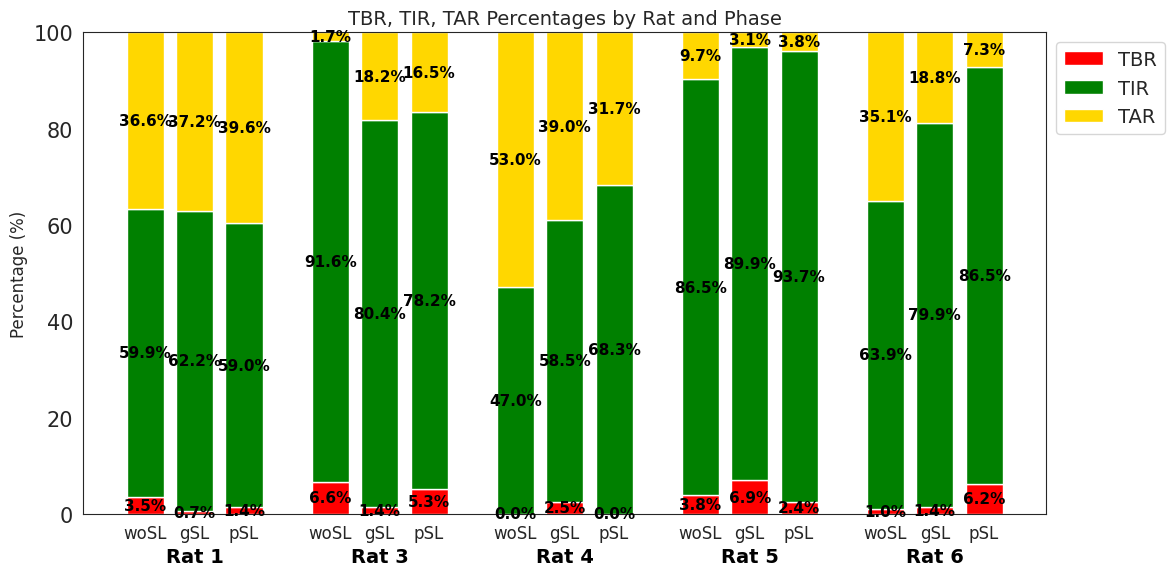

In [36]:
def calculate_metrics(group):
    hypo_thresh= 70
    total_count = len(group)  # 총 데이터 수
    tbr_count = (group['CGM'] < hypo_thresh).sum()  # TBR (70 이하)
    tar_count = (group['CGM'] >= 180).sum()  # TAR (180 이상)
    tir_count = ((group['CGM'] >= hypo_thresh) & (group['CGM'] < 180)).sum()  # TIR (70~180 사이)
    tbr54_count = (group['CGM'] < 54).sum()  # TBR54 (54 이하)
    tar250_count = (group['CGM'] >= 250).sum()  # TAR250 (250 이상)
    
    # 지표 1: 저혈당 지속 시간 (분단위)
    group = group.sort_values(by='dt')
    group['Time_diff'] = pd.to_datetime(group['dt']).diff().dt.total_seconds() / 60  # 분 단위 차이
    hypo_durations = group.loc[group['CGM'] < 70, 'Time_diff'].fillna(0).sum()  # 총 저혈당 지속 시간
    hyper_durations = group.loc[group['CGM'] > 180, 'Time_diff'].fillna(0).sum()  # 총 고혈당 지속 시간

    # 지표 3: 혈당 변동성
    glucose_std = group['CGM'].std()  # 표준편차 (SD)
    glucose_cv = (glucose_std / group['CGM'].mean()) * 100  # 변동계수 (CV%)

    return pd.Series({
        'Total_Count': total_count,
        'TBR (%)': (tbr_count / total_count) * 100 if total_count > 0 else 0,
        'TAR (%)': (tar_count / total_count) * 100 if total_count > 0 else 0,
        'TIR (%)': (tir_count / total_count) * 100 if total_count > 0 else 0,
        'TBR54 (%)': (tbr54_count / total_count) * 100 if total_count > 0 else 0,
        'TAR250 (%)': (tar250_count / total_count) * 100 if total_count > 0 else 0,
        'Hypoglycemia Duration (min)': hypo_durations,
        'Hyperglycemia Duration (min)': hyper_durations,
        'Glucose CV (%)': glucose_cv  # 변동계수 (CV%)
    })

results = []
for rat_num in [1,3,4,5,6]:    
    woSL_start, woSL_end, gSL_start, gSL_end, pSL_start, pSL_end = get_dt_info(rat_num)
    start_1, end_1 = min(woSL_start, gSL_start).date(), max(woSL_end, gSL_end).date()
    start_2, end_2 = pSL_start.date(), pSL_end.date()
    
    cgm_df = pd.read_csv(f'../../T2D_SAFETY_LAYER/data/processed_data/Rat{rat_num}/PROC_CGM.csv')
    cgm_df['dt'] = pd.to_datetime(cgm_df.dt)
    cgm_woSL = cgm_df[(cgm_df.dt >= woSL_start) & (cgm_df.dt <= woSL_end)].drop_duplicates()
    cgm_gSL = cgm_df[(cgm_df.dt >= gSL_start) & (cgm_df.dt <= gSL_end)].drop_duplicates()
    cgm_pSL = cgm_df[(cgm_df.dt >= pSL_start) & (cgm_df.dt <= pSL_end)].drop_duplicates()    

    ctrl_results = [calculate_TR(cgm_woSL), calculate_TR(cgm_gSL), calculate_TR(cgm_pSL)]
    keywords = ['woSL', 'gSL', 'pSL']
    
    _, wo_tbr, wo_tar, wo_tir, wo_tbr54, wo_tar250, wo_hypodur, wo_hyperdur, wo_cv = calculate_metrics(cgm_woSL)
    _, g_tbr, g_tar, g_tir, g_tbr54, g_tar250, g_hypodur, g_hyperdur, g_cv = calculate_metrics(cgm_gSL)
    _, p_tbr, p_tar, p_tir, p_tbr54, p_tar250, p_hypodur, p_hyperdur, p_cv = calculate_metrics(cgm_pSL)
    
    ctrl_results = [[wo_tbr, wo_tar, wo_tir, wo_tbr54, wo_tar250, wo_hypodur, wo_hyperdur, wo_cv],
                   [g_tbr, g_tar, g_tir, g_tbr54, g_tar250, g_hypodur, g_hyperdur, g_cv],
                   [p_tbr, p_tar, p_tir, p_tbr54, p_tar250, p_hypodur, p_hyperdur, p_cv]]

    for i, res in enumerate(ctrl_results):
        results.append([rat_num, keywords[i],res[0],res[1],res[2],res[3],res[4],res[5],res[6],res[7]])

df_results = pd.DataFrame(results, columns=["Rat", "Phase", "TBR", "TAR", "TIR", "TBR54", "TAR250", "HypoDuration", "HyperDuration", "CV"])
phase_order = ["woSL", "gSL", "pSL"]
df_results["Phase"] = pd.Categorical(df_results["Phase"], categories=phase_order, ordered=True)

display(df_results.groupby(['Rat', 'Phase']).mean().round(2))
display(df_results.loc[:, ['Phase','TBR', 'TBR54', 'TIR', 'TAR', 'TAR250', 'HypoDuration', 'HyperDuration', 'CV']].groupby('Phase').agg(['mean', 'std']).round(2))

fig, ax = plt.subplots(figsize=(12, 6))
rats = df_results["Rat"].unique()
phases = ["woSL", "gSL", "pSL"]

width, gap = 0.3, 0.1
x_positions,x_labels,rat_positions = [],[],[]

for i, rat in enumerate(rats):
    base_x = i * 1.5
    rat_positions.append(base_x)

    for j, phase in enumerate(phases):
        x_shift = (j - (len(phases) - 1) / 2) * (width + gap)  # 중앙으로 정렬
        x_positions.append(base_x + x_shift)
        x_labels.append(phase)

colors = {"TBR": "red", "TIR": "green", "TAR": "gold"}

tbr_values = df_results["TBR"].values
tir_values = df_results["TIR"].values
tar_values = df_results["TAR"].values

bars_tbr = ax.bar(x_positions, tbr_values, width, label="TBR", color=colors["TBR"])
bars_tir = ax.bar(x_positions, tir_values, width, bottom=tbr_values, label="TIR", color=colors["TIR"])
bars_tar = ax.bar(x_positions, tar_values, width, bottom=tbr_values + tir_values, label="TAR", color=colors["TAR"])

fontsize = 11
for i in range(len(x_positions)):
    ax.text(x_positions[i], tbr_values[i] / 2, f"{tbr_values[i]:.1f}%", ha="center", va="center", fontsize=fontsize, color="black", fontweight="bold")
    ax.text(x_positions[i], tbr_values[i] + tir_values[i] / 2, f"{tir_values[i]:.1f}%", ha="center", va="center", fontsize=fontsize, color="black", fontweight="bold")
    ax.text(x_positions[i], tbr_values[i] + tir_values[i] + tar_values[i] / 2, f"{tar_values[i]:.1f}%", ha="center", va="center", fontsize=fontsize, color="black", fontweight="bold")

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, fontsize=12)

for i, rat in enumerate(rats):
    ax.text(rat_positions[i], -10, f"Rat {rat}", ha="center", fontsize=14, fontweight="bold", color="black")

ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("TBR, TIR, TAR Percentages by Rat and Phase", fontsize=14)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize = 14)
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()


[['woSL vs gSL', 'paired t-test', '0.8033', '']]
[['woSL vs gSL', 'paired t-test', '0.8033', ''], ['woSL vs pSL', 'Wilcoxon signed-rank', '0.9645', '']]
[['woSL vs gSL', 'paired t-test', '0.8033', ''], ['woSL vs pSL', 'Wilcoxon signed-rank', '0.9645', ''], ['gSL vs pSL', 'paired t-test', '0.7996', '']]
[['woSL vs gSL', 'paired t-test', '0.3968', '']]
[['woSL vs gSL', 'paired t-test', '0.3968', ''], ['woSL vs pSL', 'paired t-test', '0.3380', '']]
[['woSL vs gSL', 'paired t-test', '0.3968', ''], ['woSL vs pSL', 'paired t-test', '0.3380', ''], ['gSL vs pSL', 'paired t-test', '0.2980', '']]
[['woSL vs gSL', 'paired t-test', '0.5364', '']]
[['woSL vs gSL', 'paired t-test', '0.5364', ''], ['woSL vs pSL', 'paired t-test', '0.3923', '']]
[['woSL vs gSL', 'paired t-test', '0.5364', ''], ['woSL vs pSL', 'paired t-test', '0.3923', ''], ['gSL vs pSL', 'paired t-test', '0.2522', '']]


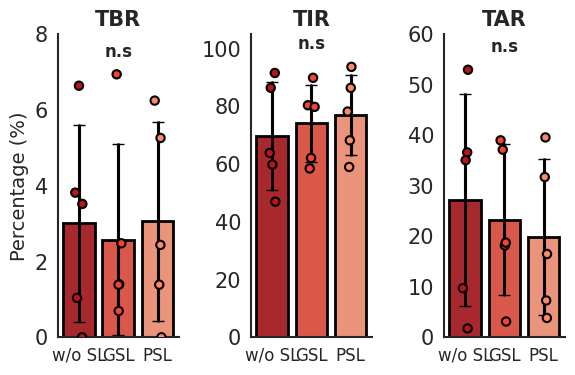

In [37]:
results = df_results.copy()

phase_order = ['woSL', 'gSL', 'pSL']
results['Phase'] = pd.Categorical(results['Phase'], categories=phase_order, ordered=True)
results.rename(columns={'TBR (%)': 'TBR', 'TIR (%)': 'TIR', 'TAR (%)': 'TAR'}, inplace=True)
selected_metrics = ['TBR', 'TIR', 'TAR']

def get_significance(p):
    if p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''

palette = sns.color_palette("Reds_r", n_colors=4)
phase_colors = {phase_order[i]: palette[i] for i in range(3)}

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
pivot_results = results.pivot_table(index='Rat', columns='Phase', values=selected_metrics)
for i, metric in enumerate(selected_metrics):
    ax = axes[i]

    bars = sns.barplot(x='Phase', y=metric, data=results, order=phase_order, ax=ax,
                       palette=phase_colors, errorbar="sd", linewidth=2, edgecolor='black')
    
    sns.stripplot(x='Phase', y=metric, data=results, order=phase_order, ax=ax, 
                  palette=phase_colors, edgecolor='black', linewidth=1.5, size=6)

    means = results.groupby('Phase')[metric].mean()
    stds = results.groupby('Phase')[metric].std()

    for j, phase in enumerate(phase_order):
        ax.errorbar(x=j, y=means[phase], yerr=stds[phase], fmt='none',
                    ecolor='black', capsize=4, linewidth=2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    pivot_metric = pivot_results[metric]
    group1 = pivot_metric['woSL'].dropna()
    group2 = pivot_metric['gSL'].dropna()
    group3 = pivot_metric['pSL'].dropna()
    group12 = pivot_metric[['woSL', 'gSL']].dropna()
    group13 = pivot_metric[['woSL', 'pSL']].dropna()
    group23 = pivot_metric[['gSL', 'pSL']].dropna()

    p_norm_12 = shapiro(group12['woSL'] - group12['gSL']).pvalue
    p_norm_13 = shapiro(group13['woSL'] - group13['pSL']).pvalue
    p_norm_23 = shapiro(group23['gSL'] - group23['pSL']).pvalue
    pairs = [
        ("woSL vs gSL", group12['woSL'], group12['gSL'], 0, 1, p_norm_12),
        ("woSL vs pSL", group13['woSL'], group13['pSL'], 0, 2, p_norm_13),
        ("gSL vs pSL", group23['gSL'], group23['pSL'], 1, 2, p_norm_23),
    ]

    stats_results = []
    y_max = results[metric].max()
    y_spacing = y_max * 0.09  # 최대값 대비 적절한 간격

    for idx, (label, g1, g2, x1, x2, p_norm) in enumerate(pairs):
        test_name = "paired t-test" if p_norm >= 0.05 else "Wilcoxon signed-rank"
        stat, p_val = ttest_rel(g1, g2)

        sig = get_significance(p_val)

        stats_results.append([label, test_name, f"{p_val:.4f}", sig])
        print(stats_results)

    y_level = y_max+ y_spacing * (idx + 0.7)
    ax.text((x1 + x2) / 3, ax.get_ylim()[1], 'n.s', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    ax.set_ylim([0, 8] if metric == 'TBR' else [0, 105] if metric == 'TIR' else [0, 60])
    ax.set_xticklabels(["w/o SL", "GSL", "PSL"], fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)" if i == 0 else "", fontsize=14)
    ax.set_title(metric, fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


## Get Safety Result

### Process Prediction Result

In [52]:
results = []

for rat_num in [1,3,4,5,6]:
    print(f"Rat#{rat_num}")

    cgm = pd.read_csv(f'../../T2D_SAFETY_LAYER/data/processed_data/Rat{rat_num}/PROC_CGM.csv');
    true = cgm.rename(columns={'dt': 'datetime'}).sort_values('datetime').loc[:, ['datetime', 'CGM']]
    true['datetime'] = pd.to_datetime(true['datetime'])

    _start, _end = true['datetime'].min(), true['datetime'].max()
    timepoints = create_timepoints(_start, _end)
    true_aligned = pd.merge_asof(timepoints, true, on='datetime', direction='nearest', tolerance=pd.Timedelta('5T'))

    woSL_start, woSL_end, gSL_start, gSL_end, pSL_start, pSL_end = get_dt_info(rat_num)
    true_gSL = true_aligned[(true_aligned.datetime >= gSL_start)&(true_aligned.datetime<=gSL_end)]
    true_pSL = true_aligned[(true_aligned.datetime >= pSL_start)&(true_aligned.datetime<=pSL_end)]

    pred = pd.read_csv(f"../../T2D_SAFETY_LAYER/data/processed_data/Rat{rat_num}/PRED.csv")
    pred['datetime'] = pd.to_datetime(pred.datetime)
    pred_gSL, pred_pSL = pred[(pred.datetime >= gSL_start)&(pred.datetime<=gSL_end)], pred[(pred.datetime >= pSL_start)&(pred.datetime<=pSL_end)]

    true_gSL['datetime'], pred_gSL['datetime'] = true_gSL.loc[:,'datetime'].dt.round('5min'), pred_gSL.loc[:,'datetime'].dt.round('5min')
    true_gSL['datetime'] = pd.to_datetime(true_gSL['datetime']) + pd.Timedelta(minutes=5)
    pred_true_gSL = pred_gSL.merge(true_gSL, how='left', on='datetime').dropna()

    true_pSL['datetime'], pred_pSL['datetime'] = true_pSL.loc[:,'datetime'].dt.round('5min'), pred_pSL.loc[:,'datetime'].dt.round('5min')
    true_pSL['datetime'] = pd.to_datetime(true_pSL['datetime']) + pd.Timedelta(minutes=5)
    pred_true_pSL = pred_pSL.merge(true_pSL, how='left', on='datetime').dropna()
    
    rmse_gSL, rmse_pSL = RMSE(pred_true_gSL.CGM, pred_true_gSL.invRegMean), RMSE(pred_true_pSL.CGM, pred_true_pSL.invRegMean)
    sens_gSL, spec_gSL, acc_gSL, f1_gSL = GET_CLF_RES(pred_true_gSL)
    sens_pSL, spec_pSL, acc_pSL, f1_pSL = GET_CLF_RES(pred_true_pSL)
    mae_gSL, mae_pSL = MAE(pred_true_gSL.CGM, pred_true_gSL.invRegMean), MAE(pred_true_pSL.CGM, pred_true_pSL.invRegMean)
    
    results.append({
        'Rat#': rat_num,
        'RMSE_gSL': rmse_gSL,
        'MAE_gSL': mae_gSL,
        'Sens_gSL': sens_gSL,
        'Spec_gSL': spec_gSL,
        'Acc_gSL': acc_gSL,
        'RMSE_pSL': rmse_pSL,
        'MAE_pSL': mae_pSL,
        'Sens_pSL': sens_pSL,
        'Spec_pSL': spec_pSL,
        'Acc_pSL': acc_pSL
    })
    
results_df = pd.DataFrame(results)
results_df = results_df[['Rat#','RMSE_gSL','MAE_gSL','Sens_gSL', 'Spec_gSL', 'Acc_gSL', 'RMSE_pSL', 'MAE_pSL', 'Sens_pSL', 'Spec_pSL', 'Acc_pSL']]
display(results_df.round(2))
display(results_df.agg(['mean','std']).round(2))

Rat#1
Rat#3
Rat#4
There is no hypo case
Rat#5
Rat#6


,Rat#,RMSE_gSL,MAE_gSL,Sens_gSL,Spec_gSL,Acc_gSL,RMSE_pSL,MAE_pSL,Sens_pSL,Spec_pSL,Acc_pSL
0,1,45.29,36.85,50.00,92.63,92.33,29.86,25.26,75.00,90.11,89.90
1,3,40.12,32.45,50.00,93.95,93.33,20.46,14.64,86.67,92.91,92.58
2,4,51.60,39.30,57.14,92.70,91.81,36.93,23.52,NaN,95.19,95.19
3,5,31.07,23.32,45.00,93.26,89.90,33.15,25.22,85.71,96.40,96.14
4,6,38.52,31.11,75.00,95.05,94.77,22.72,16.99,77.78,93.68,92.68


,Rat#,RMSE_gSL,MAE_gSL,Sens_gSL,Spec_gSL,Acc_gSL,RMSE_pSL,MAE_pSL,Sens_pSL,Spec_pSL,Acc_pSL
mean,3.80,41.32,32.61,55.43,93.52,92.43,28.62,21.13,81.29,93.66,93.30
std,1.92,7.68,6.15,11.77,1.01,1.81,6.94,4.97,5.78,2.40,2.46
